# Практическая работа 6 / Лабораторная работа 4
Выполнил Агишевский П. Д. ББМО-02-22

Импортируем библиотеки для проведения работы и подключим ГПУ:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

Проверим ГПУ. Первоначально необходимо сменить среду выполнения в Google Colab.

In [2]:
!nvidia-smi

Sun Jan 28 16:36:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
print(torch.cuda.is_available())

use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

True


Сформируем преобразователь для нормализации входных данных.

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])

Загрузим набор данных и разделим его на выборки.

In [5]:
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)

train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 179255874.47it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 119936330.52it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35181410.92it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21453298.16it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

In [7]:
print("Длина обучающей выборки:", len(train_loader),"\nДлина валидационной выборки:", len(val_loader), "\nДлина тестовой выборки:", len(test_loader))

Длина обучающей выборки: 50000 
Длина валидационной выборки: 10000 
Длина тестовой выборки: 10000


Подготовим структуру нейронной сети. Конструктор и функция продвижения. Слои.

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [9]:
model = Net().to(device)

Оптимизация, функция потери.

In [10]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Функция для обучения НС. Обучение модели.

In [11]:
def fit(model, device, train_loader, val_loader, epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Обучение модели...")

  train_loss, val_loss=[], []

  for epoch in range(epochs):
    loss_per_epoch, val_loss_per_epoch=0, 0

    for phase in ('train','val'):
      for i, data in enumerate(data_loader[phase]):
        input, label = data[0].to(device), data[1].to(device)

        output = model(input)

        loss = criterion(output, label)
        if phase == 'train':
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          loss_per_epoch += loss.item()
        else:
          val_loss_per_epoch+=loss.item()

    scheduler.step(val_loss_per_epoch/len(val_loader))

    print("Эпоха: {} Потери: {} Потери (валидация): {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))

  return train_loss,val_loss


In [12]:
%time
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
Обучение модели...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Эпоха: 1 Потери: 0.3029698184566989 Потери (валидация): 0.1385907901983114
Эпоха: 2 Потери: 0.11664045373087592 Потери (валидация): 0.09800908826177844
Эпоха: 3 Потери: 0.08733526865661408 Потери (валидация): 0.09060460145605478
Эпоха: 4 Потери: 0.07697809133515497 Потери (валидация): 0.07489745397494352
Эпоха: 5 Потери: 0.07135913080704039 Потери (валидация): 0.07832663779480133
Эпоха: 6 Потери: 0.0639874085114288 Потери (валидация): 0.07664083025356043
Эпоха: 7 Потери: 0.061638865242157496 Потери (валидация): 0.07216797071834846
Эпоха: 8 Потери: 0.058360278748741064 Потери (валидация): 0.07462195197658184
Эпоха: 9 Потери: 0.05656761664028165 Потери (валидация): 0.07356026017036393
Эпоха: 10 Потери: 0.05740193898322404 Потери (валидация): 0.09115530531275556


График потерь при обучении и валидации. По эпохам.

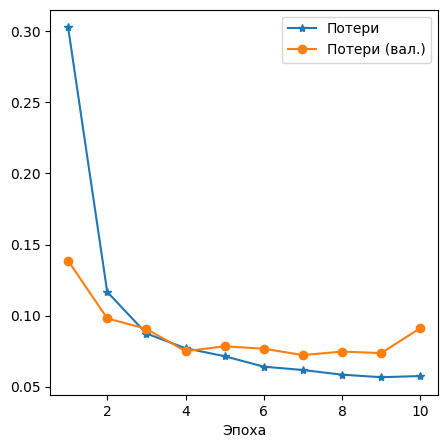

In [13]:
fig = plt.figure(figsize=(5,5))

plt.plot(np.arange(1, 11), loss, "*-", label="Потери")
plt.plot(np.arange(1, 11), val_loss, "o-", label="Потери (вал.)")
plt.xlabel("Эпоха")

plt.legend()
plt.show()

## Подготовка атак.
Функции для атак FGSM, I-FGSM, MI-FGSM.

In [14]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

Функция для тестирования.

In [15]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)

    data.requires_grad = True
    output = model(data)

    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue

    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()

    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)

    output = model(perturbed_data)

    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))

  print("Эпсилон: {}\tТочность (тест) = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc, adv_examples

## Графики точности атак. Примеры атак.

Эпсилон: 0	Точность (тест) = 9630 / 10000 = 0.963
Эпсилон: 0.007	Точность (тест) = 9620 / 10000 = 0.962
Эпсилон: 0.01	Точность (тест) = 9596 / 10000 = 0.9596
Эпсилон: 0.02	Точность (тест) = 9540 / 10000 = 0.954
Эпсилон: 0.03	Точность (тест) = 9458 / 10000 = 0.9458
Эпсилон: 0.05	Точность (тест) = 9269 / 10000 = 0.9269
Эпсилон: 0.1	Точность (тест) = 8606 / 10000 = 0.8606
Эпсилон: 0.2	Точность (тест) = 6638 / 10000 = 0.6638
Эпсилон: 0.3	Точность (тест) = 4534 / 10000 = 0.4534


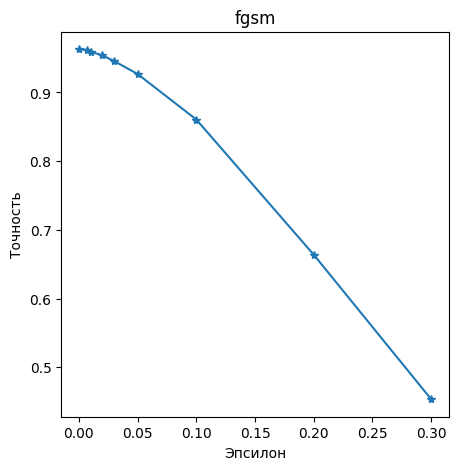

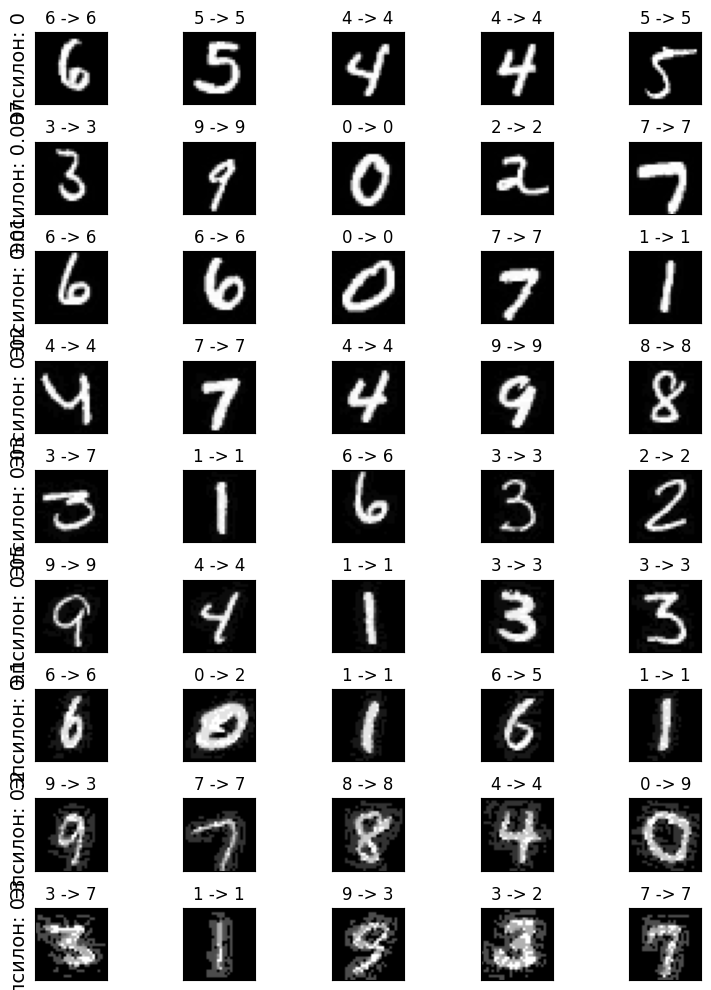

Эпсилон: 0	Точность (тест) = 9622 / 10000 = 0.9622
Эпсилон: 0.007	Точность (тест) = 9621 / 10000 = 0.9621
Эпсилон: 0.01	Точность (тест) = 9580 / 10000 = 0.958
Эпсилон: 0.02	Точность (тест) = 9546 / 10000 = 0.9546
Эпсилон: 0.03	Точность (тест) = 9478 / 10000 = 0.9478
Эпсилон: 0.05	Точность (тест) = 9295 / 10000 = 0.9295
Эпсилон: 0.1	Точность (тест) = 8734 / 10000 = 0.8734
Эпсилон: 0.2	Точность (тест) = 7051 / 10000 = 0.7051
Эпсилон: 0.3	Точность (тест) = 5261 / 10000 = 0.5261


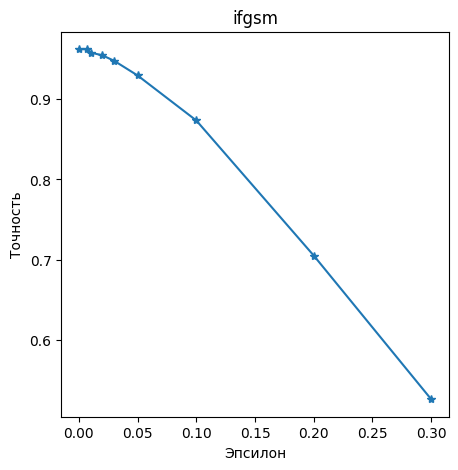

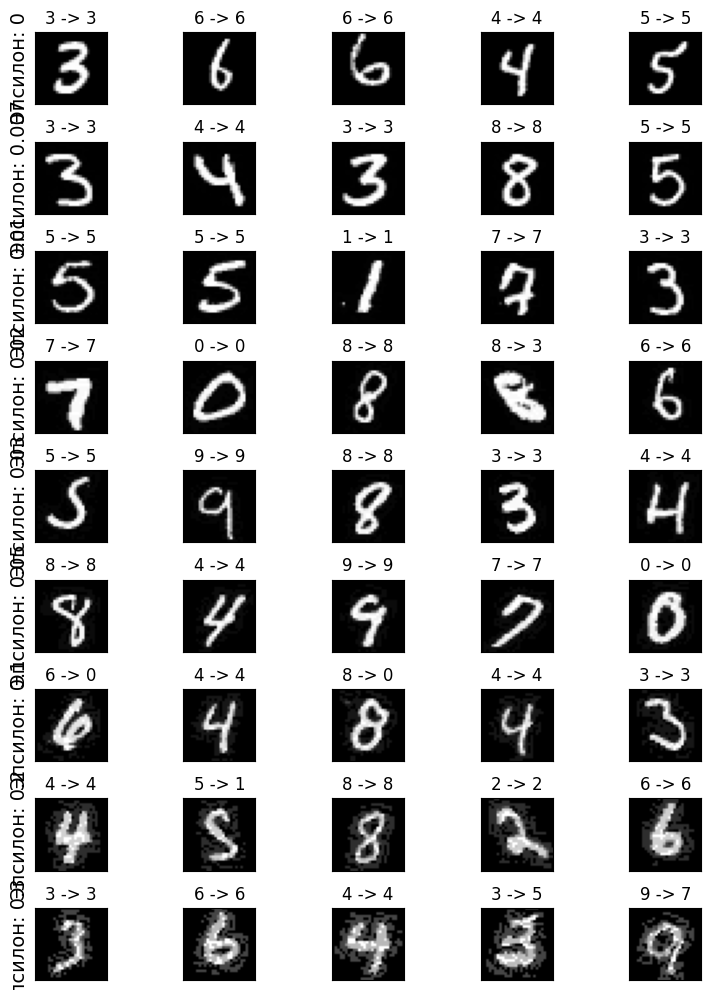

Эпсилон: 0	Точность (тест) = 9648 / 10000 = 0.9648
Эпсилон: 0.007	Точность (тест) = 9598 / 10000 = 0.9598
Эпсилон: 0.01	Точность (тест) = 9588 / 10000 = 0.9588
Эпсилон: 0.02	Точность (тест) = 9518 / 10000 = 0.9518
Эпсилон: 0.03	Точность (тест) = 9497 / 10000 = 0.9497
Эпсилон: 0.05	Точность (тест) = 9325 / 10000 = 0.9325
Эпсилон: 0.1	Точность (тест) = 8708 / 10000 = 0.8708
Эпсилон: 0.2	Точность (тест) = 7061 / 10000 = 0.7061
Эпсилон: 0.3	Точность (тест) = 5181 / 10000 = 0.5181


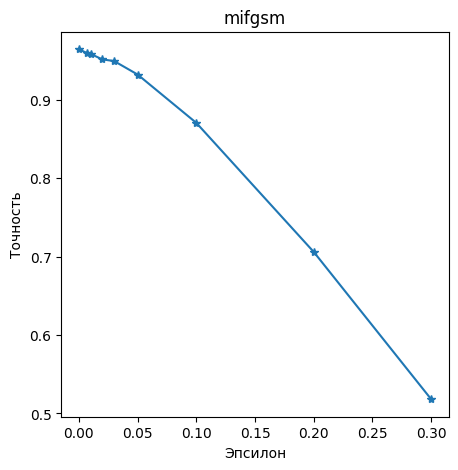

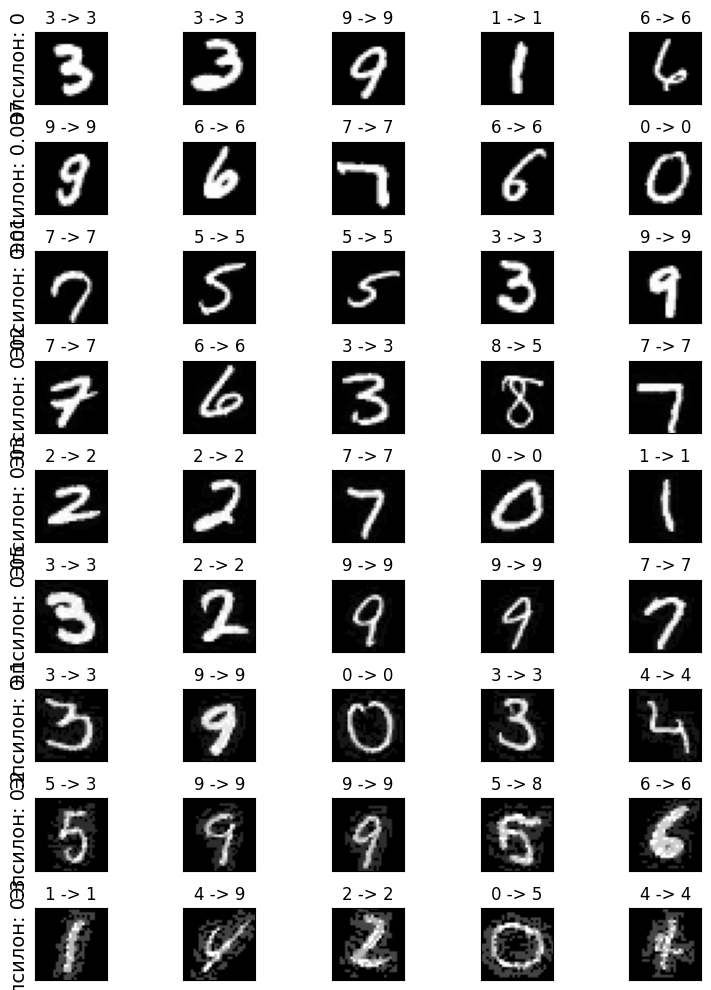

In [16]:
epsilons = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []

  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)

  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Эпсилон")
  plt.ylabel("Точность")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))

  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])

      if j == 0:
        plt.ylabel("Эпсилон: {}".format(epsilons[i]), fontsize=14)

      orig, adv, ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")

  plt.tight_layout()
  plt.show()

## Защита от атак
Подготовка функций для защиты НС. Функции обучения и проверки (тестирования).

In [17]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [18]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader, 'val':val_loader}
  print("Обучение модели...")

  train_loss, val_loss=[], []

  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)

        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()

    scheduler.step(val_loss_per_epoch / len(val_loader))

    print("Эпоха: {} Потери: {} Потери (валидация): {}".format(epoch+1, loss_per_epoch / len(train_loader), val_loss_per_epoch / len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))

  return train_loss,val_loss

  def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []

    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)

      output = F.log_softmax(output/Temp,dim=1)
      init_pred = output.max(1, keepdim=True)[1]

      if init_pred.item() != target.item():
        continue

      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()

      data_grad = data.grad.data
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)

      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]

      if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Эпсилон: {}\tТочность (тест) = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

Функция для защиты.

In [19]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)

  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)

  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF, val_lossF = fit(modelF, device, optimizerF, schedulerF, criterion, train_loader, val_loader, Temp, epochs)

  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  lossF1, val_lossF1 = fit(modelF1, device, optimizerF1, schedulerF1, criterion, train_loader, val_loader, Temp, epochs)

  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())

  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)

    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()
    cnt = 0
    plt.figure(figsize=(8,10))

    for i in range(len(epsilons)):
      for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
          plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

## Результаты оценки защищённых сетей

Обучение модели...
Эпоха: 1 Потери: 0.5757089218403886 Потери (валидация): 7.236343920230865e-05
Эпоха: 2 Потери: 0.36198810768139594 Потери (валидация): 6.441801087930799e-07
Эпоха: 3 Потери: 0.2767571794908862 Потери (валидация): 1.0505147161893546e-06
Эпоха: 4 Потери: 0.2049651647188014 Потери (валидация): 0.0001482546220184304
Эпоха: 5 Потери: 0.1647207663291951 Потери (валидация): 2.6401976123452186e-05
Эпоха: 6 Потери: 0.14019280280385618 Потери (валидация): 1.6727904975414276e-05
Эпоха: 7 Потери: 0.12014286763126937 Потери (валидация): 2.6576557462249183e-06
Эпоха: 8 Потери: 0.11623238818842468 Потери (валидация): 6.534938293043525e-08
Эпоха: 9 Потери: 0.11257952472579412 Потери (валидация): 4.05310810691617e-10
Эпоха: 10 Потери: 0.11174146020839586 Потери (валидация): 6.5256372094147256e-06


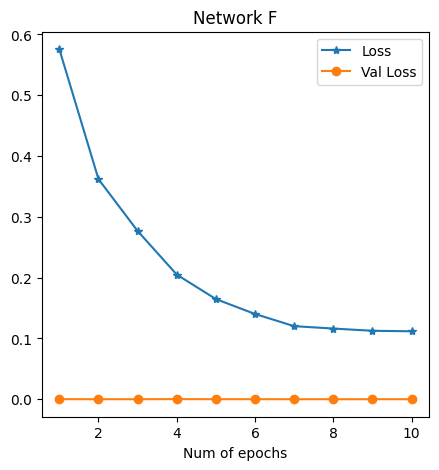

Обучение модели...
Эпоха: 1 Потери: 0.704467915649509 Потери (валидация): 6.366536626592278e-06
Эпоха: 2 Потери: 0.4594781201902626 Потери (валидация): 0.0006416387513279915
Эпоха: 3 Потери: 0.37828087008411565 Потери (валидация): 9.178650095127523e-05
Эпоха: 4 Потери: 0.30384029590901773 Потери (валидация): 4.8963382840156554e-05
Эпоха: 5 Потери: 0.25672006460775415 Потери (валидация): 1.0490583349019288e-05
Эпоха: 6 Потери: 0.22537640054141678 Потери (валидация): 1.0251131674158387e-05
Эпоха: 7 Потери: 0.22199416591925628 Потери (валидация): 7.130625570425763e-07
Эпоха: 8 Потери: 0.2147434249551388 Потери (валидация): 1.4802867887192405e-05
Эпоха: 9 Потери: 0.21084802750144407 Потери (валидация): 7.095624207013316e-05
Эпоха: 10 Потери: 0.21181874544916074 Потери (валидация): 7.049936102703213e-08


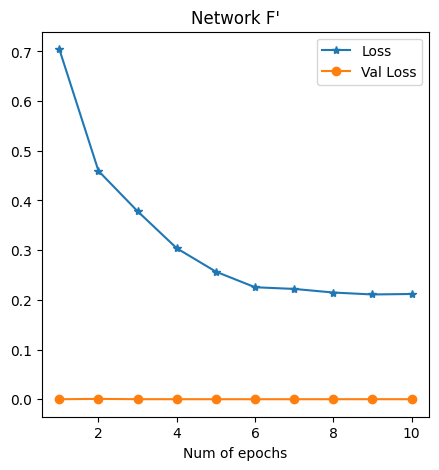

Эпсилон: 0	Точность (тест) = 9115 / 10000 = 0.9115
Эпсилон: 0.007	Точность (тест) = 9050 / 10000 = 0.905
Эпсилон: 0.01	Точность (тест) = 9029 / 10000 = 0.9029
Эпсилон: 0.02	Точность (тест) = 8942 / 10000 = 0.8942
Эпсилон: 0.03	Точность (тест) = 8876 / 10000 = 0.8876
Эпсилон: 0.05	Точность (тест) = 8552 / 10000 = 0.8552
Эпсилон: 0.1	Точность (тест) = 7703 / 10000 = 0.7703
Эпсилон: 0.2	Точность (тест) = 4118 / 10000 = 0.4118
Эпсилон: 0.3	Точность (тест) = 1035 / 10000 = 0.1035


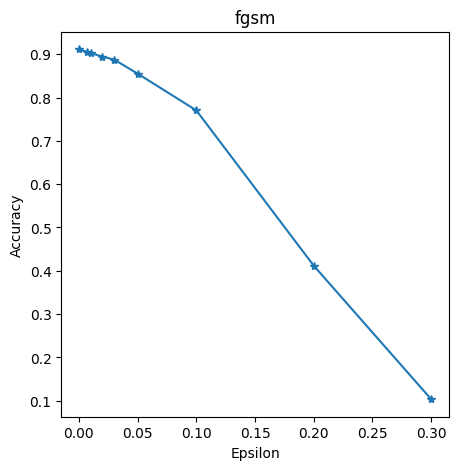

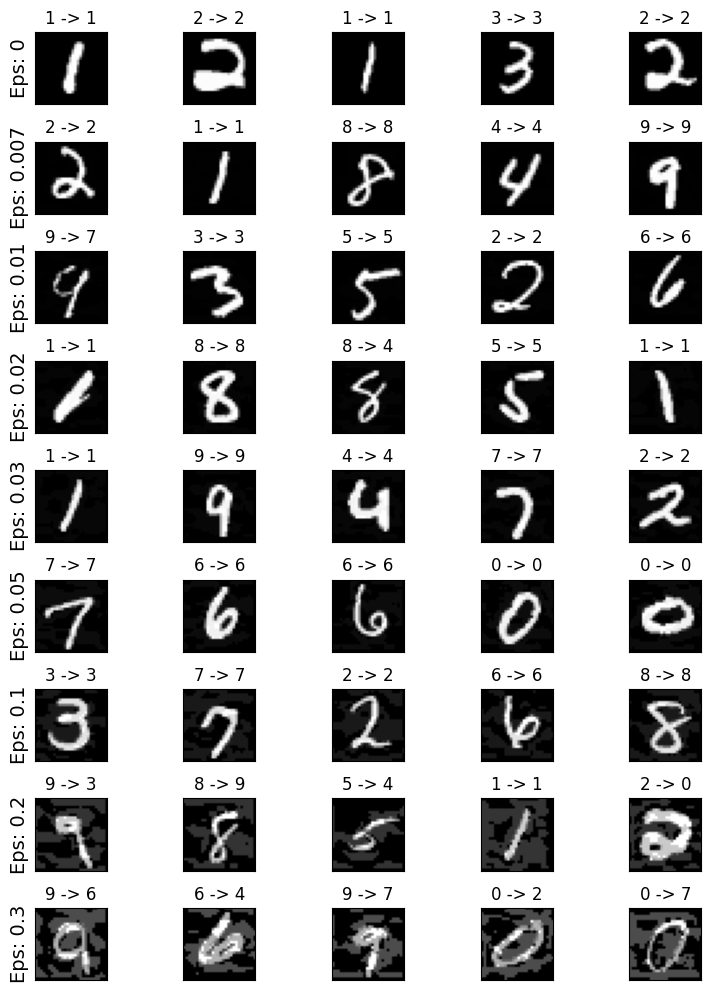

Эпсилон: 0	Точность (тест) = 9072 / 10000 = 0.9072
Эпсилон: 0.007	Точность (тест) = 9042 / 10000 = 0.9042
Эпсилон: 0.01	Точность (тест) = 8983 / 10000 = 0.8983
Эпсилон: 0.02	Точность (тест) = 8902 / 10000 = 0.8902
Эпсилон: 0.03	Точность (тест) = 8844 / 10000 = 0.8844
Эпсилон: 0.05	Точность (тест) = 8658 / 10000 = 0.8658
Эпсилон: 0.1	Точность (тест) = 7899 / 10000 = 0.7899
Эпсилон: 0.2	Точность (тест) = 4971 / 10000 = 0.4971
Эпсилон: 0.3	Точность (тест) = 1654 / 10000 = 0.1654


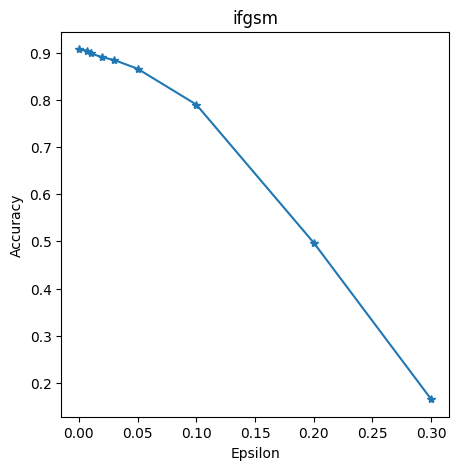

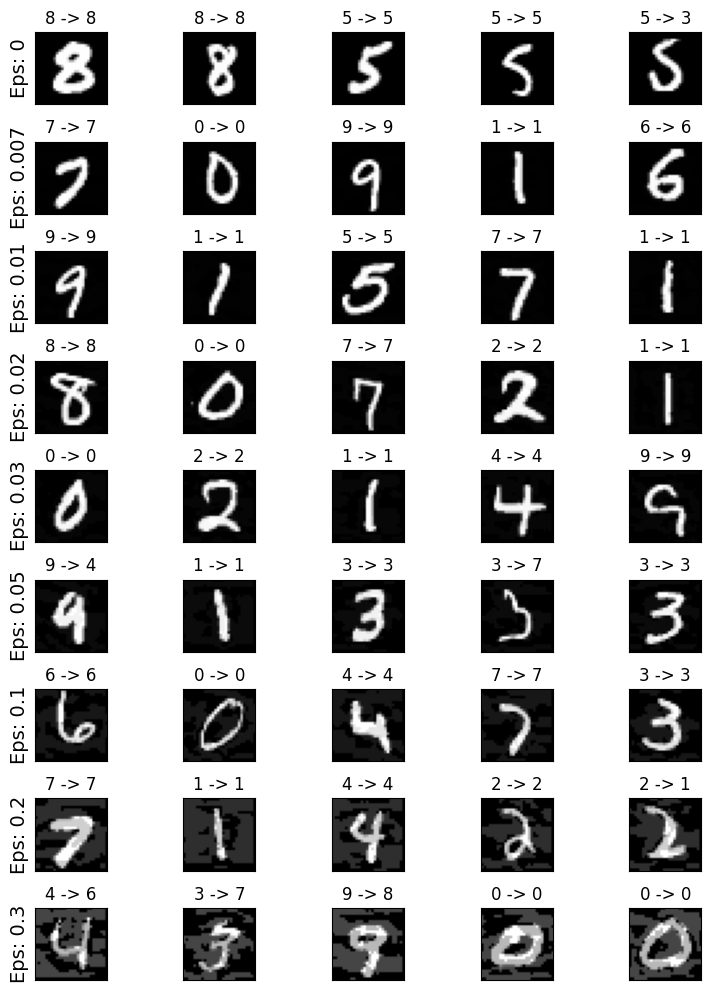

Эпсилон: 0	Точность (тест) = 9083 / 10000 = 0.9083
Эпсилон: 0.007	Точность (тест) = 9033 / 10000 = 0.9033
Эпсилон: 0.01	Точность (тест) = 9007 / 10000 = 0.9007
Эпсилон: 0.02	Точность (тест) = 8945 / 10000 = 0.8945
Эпсилон: 0.03	Точность (тест) = 8842 / 10000 = 0.8842
Эпсилон: 0.05	Точность (тест) = 8655 / 10000 = 0.8655
Эпсилон: 0.1	Точность (тест) = 7897 / 10000 = 0.7897
Эпсилон: 0.2	Точность (тест) = 5025 / 10000 = 0.5025
Эпсилон: 0.3	Точность (тест) = 1642 / 10000 = 0.1642


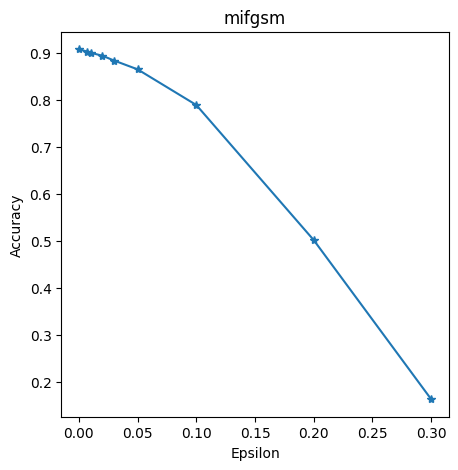

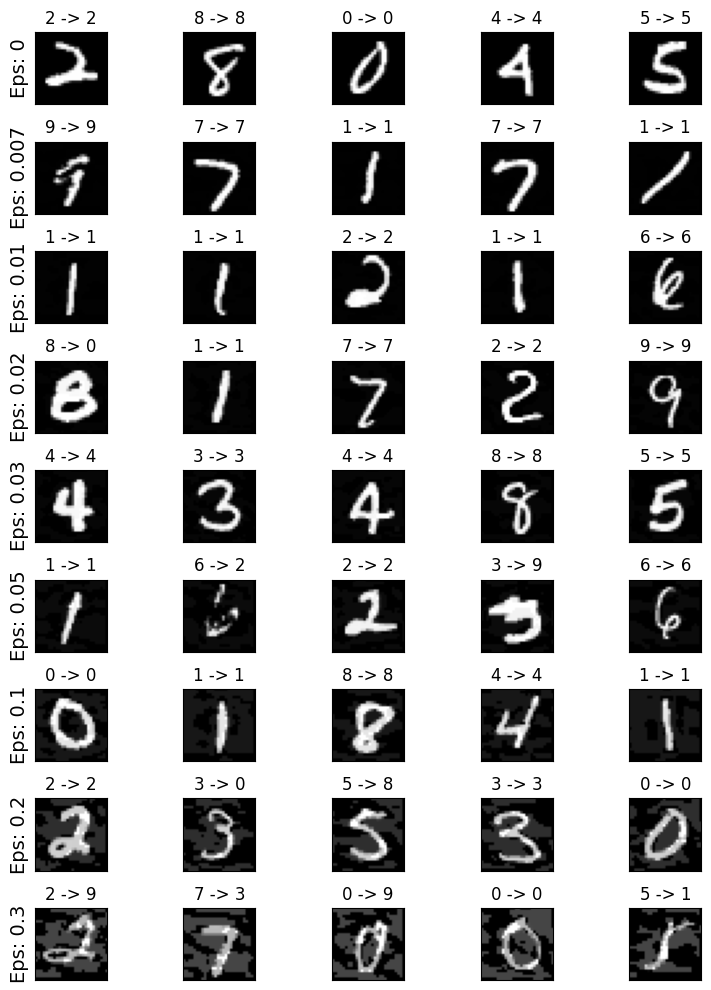

In [20]:
Temp = 100
epochs = 10
epsilons = [0, 0.007, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
defense(device, train_loader, val_loader, test_loader, epochs, Temp, epsilons)

# Выводы:
В данной работе мы успешно создали модели и загрузили данные, обучили их, протестировали и применили
защитную дистилляцию.

Как можно заметить, после применения алгоритма по защите модели, результат работы был улучшен. Не смотря на это, в данном случае полностью восстановить работоспособность и защитить модель полностью не удалось. Вероятно, это зависит от показателей упсилон и сложности модели, а также от объема данных обучения и тестирования выборок.
Результат проделанной работы демонстрирует улучшение в работе модели, подвергшейся атаке.  